# 🎬 Stable Diffusion (Img2Img) → Vídeo com Retroalimentação

Este notebook permite:
- Fazer upload de uma imagem inicial
- Gerar frames com Stable Diffusion (img2img), usando o frame anterior como entrada (retroalimentação)
- Exportar os frames para um vídeo MP4

Dica: Execute célula por célula de cima para baixo no Google Colab.


In [1]:
# Instalação de dependências
%pip -q install diffusers==0.30.0 transformers accelerate safetensors "imageio[ffmpeg]" pillow
# OpenVINO é opcional; no Colab (x86) funciona, em M1/M2 pode não
%pip -q install "optimum[openvino]" --extra-index-url https://download.pytorch.org/whl/cpu

# FFmpeg já está no Colab; se não estiver:
!apt -y update && apt -y install ffmpeg || true


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
zsh:1: command not found: apt


In [2]:
# Função robusta de geração e alias para compatibilidade
from PIL import Image
import numpy as np


def _ensure_rgb_hw(img, width, height):
    if isinstance(img, Image.Image):
        im = img.convert('RGB') if img.mode != 'RGB' else img
    elif isinstance(img, np.ndarray):
        im = Image.fromarray(img.astype(np.uint8)).convert('RGB')
    else:
        im = Image.fromarray(np.array(img).astype(np.uint8)).convert('RGB')
    w = (int(width) // 8) * 8
    h = (int(height) // 8) * 8
    if im.size != (w, h):
        im = im.resize((w, h), Image.LANCZOS)
    return im


def generate_next_frame_v2(prev_img, prompt: str):
    im = _ensure_rgb_hw(prev_img, getattr(cfg, 'width', 512), getattr(cfg, 'height', 512))

    # Gerador (seed variável)
    generator = None
    if 'torch' in globals() and getattr(cfg, 'seed', None) is not None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        generator = torch.Generator(device=device).manual_seed(int(cfg.seed) + np.random.randint(1, 10))

    # Preferir img2img quando disponível
    if 'pipe_img2img' in globals() and pipe_img2img is not None:
        try:
            out = pipe_img2img(
                prompt=prompt,
                negative_prompt=getattr(cfg, 'negative_prompt', ''),
                image=im,
                strength=getattr(cfg, 'strength', 0.65),
                num_inference_steps=getattr(cfg, 'steps', 25),
                guidance_scale=getattr(cfg, 'guidance', 7.5),
                generator=generator,
            )
            return out.images[0]
        except Exception as e:
            print('Img2Img falhou, a usar txt2img:', e)

    # Fallback txt2img
    out = pipe_txt2img(
        prompt=prompt,
        negative_prompt=getattr(cfg, 'negative_prompt', ''),
        width=im.width,
        height=im.height,
        num_inference_steps=getattr(cfg, 'steps', 25),
        guidance_scale=getattr(cfg, 'guidance', 7.5),
        generator=generator,
    )
    return out.images[0]

# Alias para compatibilidade com células antigas
generate_next_frame = generate_next_frame_v2
print('Função de geração ativa: generate_next_frame_v2 (alias generate_next_frame)')


Função de geração ativa: generate_next_frame_v2 (alias generate_next_frame)


In [3]:
# Configurações
from dataclasses import dataclass
from typing import Optional, List

@dataclass
class SDConfig:
    model_id: str = "runwayml/stable-diffusion-v1-5"
    use_openvino: bool = False
    width: int = 512
    height: int = 512
    steps: int = 25
    guidance: float = 7.5
    strength: float = 0.65
    seed: Optional[int] = 42
    frames: int = 24
    fps: int = 12
    negative_prompt: str = ""

cfg = SDConfig()
print(cfg)


SDConfig(model_id='runwayml/stable-diffusion-v1-5', use_openvino=False, width=512, height=512, steps=25, guidance=7.5, strength=0.65, seed=42, frames=24, fps=12, negative_prompt='')


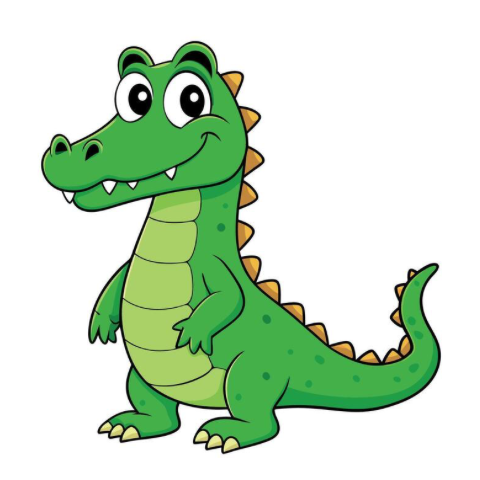

In [4]:
# Upload de imagem inicial
try:
    from google.colab import files  # no Colab
except Exception:
    files = None

from PIL import Image
import io
from IPython.display import display

if files is not None:
    print("Selecione uma imagem (PNG/JPG)...")
    uploaded = files.upload()
    init_img = None
    if uploaded:
        name, data = next(iter(uploaded.items()))
        init_img = Image.open(io.BytesIO(data)).convert("RGB")
        display(init_img)
    else:
        raise RuntimeError("Nenhuma imagem enviada.")
else:
    # fallback: carregar de caminho local
    fallback_path = "jacaré.png"
    init_img = Image.open(fallback_path).convert("RGB")
    display(init_img)


Imagem inicial pronta ( generated:gray )


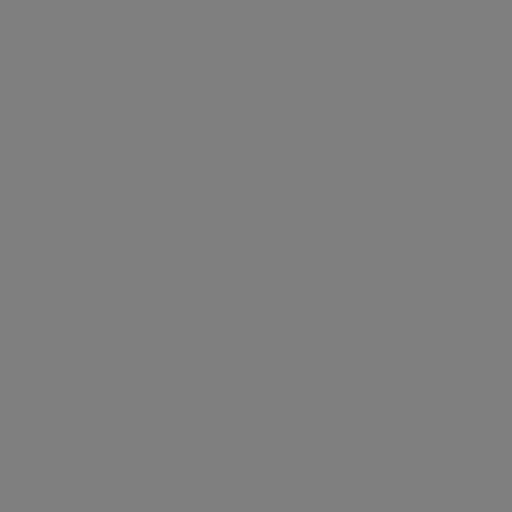

In [5]:
# Upload/Fallback unificado (Colab e Jupyter local)
from PIL import Image
import io

init_img = None
source = None

# 1) Colab (se disponível)
try:
    from google.colab import files  # type: ignore
    print("Colab detetado: selecione um ficheiro...")
    uploaded = files.upload()
    if uploaded:
        name, data = next(iter(uploaded.items()))
        init_img = Image.open(io.BytesIO(data)).convert("RGB")
        source = f"colab:{name}"
except Exception:
    pass

# 2) Jupyter local com ipywidgets (se disponível)
if init_img is None:
    try:
        import ipywidgets as widgets
        from IPython.display import display
        uploader = widgets.FileUpload(accept='.png,.jpg,.jpeg', multiple=False)
        display(uploader)
        print("Carregue um ficheiro acima e volte a executar esta célula para processar.")
        if uploader.value:
            file_info = list(uploader.value.values())[0]
            init_img = Image.open(io.BytesIO(file_info['content'])).convert("RGB")
            source = f"ipywidgets:{file_info.get('metadata', {}).get('name', 'upload')}"
    except Exception:
        pass

# 3) Caminho local (opcional)
if init_img is None:
    local_image_path = ""  # defina aqui para usar um ficheiro local
    if local_image_path:
        try:
            init_img = Image.open(local_image_path).convert("RGB")
            source = f"local:{local_image_path}"
        except Exception as e:
            print(f"Falha ao abrir {local_image_path}: {e}")

# 4) Fallbacks
if init_img is None:
    try:
        fallback_path = "example_frames/gradient_frame_0000.png"
        init_img = Image.open(fallback_path).convert("RGB")
        source = f"fallback:{fallback_path}"
    except Exception:
        init_img = Image.new("RGB", (cfg.width, cfg.height), (127, 127, 127))
        source = "generated:gray"

print("Imagem inicial pronta (", source, ")")
try:
    from IPython.display import display
    display(init_img)
except Exception:
    pass


In [6]:
# Forçar imagem local fornecida pelo utilizador
from PIL import Image
from pathlib import Path

user_image_path = "/Users/alansms/stable_diffusion_video_generator/jacaré.png"

try:
    p = Path(user_image_path)
    if p.exists():
        init_img = Image.open(p).convert("RGB")
        print(f"Imagem inicial carregada de: {p}")
    else:
        print(f"Aviso: caminho não encontrado: {p}. Usar upload/fallback.")
except Exception as e:
    print(f"Falha ao abrir a imagem do utilizador: {e}. Usar upload/fallback.")


Imagem inicial carregada de: /Users/alansms/stable_diffusion_video_generator/jacaré.png


Usando imagem neutra gerada (cinza)


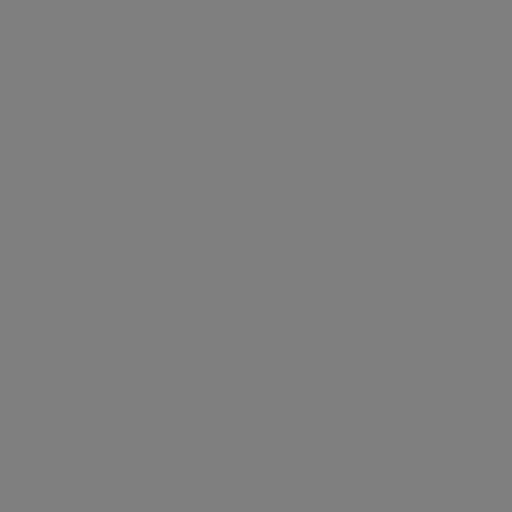

In [7]:
# Upload de imagem 
from PIL import Image
import io

init_img = None

# 1) Tentar Colab (se disponível)
try:
    from google.colab import files  # type: ignore
    print("Colab detectado: selecione um ficheiro...")
    uploaded = files.upload()
    if uploaded:
        name, data = next(iter(uploaded.items()))
        init_img = Image.open(io.BytesIO(data)).convert("RGB")
except Exception:
    pass

# 2) Tentar Jupyter local com ipywidgets (se disponível)
if init_img is None:
    try:
        import ipywidgets as widgets
        from IPython.display import display
        uploader = widgets.FileUpload(accept='.png,.jpg,.jpeg', multiple=False)
        display(uploader)
        print("Carregue um ficheiro acima e volte a executar esta célula para processar.")
        if uploader.value:
            file_info = list(uploader.value.values())[0]
            init_img = Image.open(io.BytesIO(file_info['content'])).convert("RGB")
            print("Imagem carregada via ipywidgets.")
    except Exception:
        pass

# 3) Tentar por caminho local configurável
if init_img is None:
    local_image_path = ""  # Defina um caminho se quiser usar um ficheiro local
    if local_image_path:
        try:
            init_img = Image.open(local_image_path).convert("RGB")
            print(f"Imagem carregada: {local_image_path}")
        except Exception as e:
            print(f"Falha ao abrir {local_image_path}: {e}")

# 4) Fallbacks: exemplo ou imagem neutra
if init_img is None:
    try:
        fallback_path = "example_frames/gradient_frame_0000.png"
        init_img = Image.open(fallback_path).convert("RGB")
        print(f"Usando fallback local: {fallback_path}")
    except Exception:
        init_img = Image.new("RGB", (cfg.width, cfg.height), (127, 127, 127))
        print("Usando imagem neutra gerada (cinza)")

# Mostrar
try:
    from IPython.display import display
    display(init_img)
except Exception:
    pass


### Garantir imagem inicial
Execute esta célula após o upload. Se não houver upload, usa um exemplo local ou gera uma imagem neutra.


In [8]:
# Fallback automático da imagem inicial
from PIL import Image

if 'init_img' not in globals() or init_img is None:
    try:
        fallback_path = "example_frames/gradient_frame_0000.png"
        init_img = Image.open(fallback_path).convert("RGB")
        print(f"Usando fallback local: {fallback_path}")
    except Exception:
        init_img = Image.new("RGB", (cfg.width, cfg.height), (127, 127, 127))
        print("Usando imagem neutra gerada (cinza)")


In [9]:
# Pipeline Stable Diffusion com suporte a img2img
import torch
from diffusers import StableDiffusionImg2ImgPipeline, StableDiffusionPipeline, DPMSolverMultistepScheduler

pipe = None
if cfg.use_openvino:
    try:
        from optimum.intel import OVStableDiffusionPipeline
        pipe = OVStableDiffusionPipeline.from_pretrained(cfg.model_id, export=True, compile=False)
        pipe.compile()
        print("OpenVINO ativo")
    except Exception as e:
        print("Falha OpenVINO, usando PyTorch:", e)

if pipe is None:
    try:
        pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
            cfg.model_id,
            torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
            safety_checker=None,
            requires_safety_checker=False,
        )
    except Exception:
        pipe = StableDiffusionPipeline.from_pretrained(
            cfg.model_id,
            torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
            safety_checker=None,
            requires_safety_checker=False,
        )

try:
    pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
except Exception:
    pass

if torch.cuda.is_available():
    pipe = pipe.to("cuda")

print("Pipeline pronto")


/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading pipeline components...: 100%|██████████| 6/6 [00:00<00:00, 29.01it/s]

Pipeline pronto


In [10]:
# Funções de geração
import numpy as np
from typing import List


def generate_first_image(prompt: str):
    generator = torch.Generator(device="cuda" if torch.cuda.is_available() else "cpu") if cfg.seed is not None else None
    if generator is not None:
        generator = generator.manual_seed(cfg.seed)
    result = pipe(
        prompt=prompt,
        negative_prompt=cfg.negative_prompt,
        width=cfg.width,
        height=cfg.height,
        num_inference_steps=cfg.steps,
        guidance_scale=cfg.guidance,
        generator=generator,
    )
    return result.images[0]


def generate_next_frame(prev_img, prompt: str):
    generator = torch.Generator(device="cuda" if torch.cuda.is_available() else "cpu") if cfg.seed is not None else None
    if generator is not None:
        new_seed = int(cfg.seed) + np.random.randint(1, 10)
        generator = generator.manual_seed(new_seed)
    # Img2img se suportado
    if hasattr(pipe, "__call__") and "image" in pipe.__call__.__code__.co_varnames:
        out = pipe(
            prompt=prompt,
            negative_prompt=cfg.negative_prompt,
            image=prev_img,
            strength=cfg.strength,
            num_inference_steps=cfg.steps,
            guidance_scale=cfg.guidance,
            generator=generator,
        )
        return out.images[0]
    # Fallback txt2img
    out = pipe(
        prompt=prompt,
        negative_prompt=cfg.negative_prompt,
        num_inference_steps=cfg.steps,
        guidance_scale=cfg.guidance,
        generator=generator,
    )
    return out.images[0]


In [11]:
# Imports auxiliares para esta sessão
from typing import List


In [12]:
# Gerar frames com retroalimentação
initial_prompt = "continue the theme of the uploaded image, cinematic, detailed"
frame_prompts: List[str] = []

frames = []
init_resized = init_img.resize((cfg.width, cfg.height), Image.LANCZOS)
frames.append(init_resized)
current = init_resized

for i in range(1, cfg.frames):
    prompt = frame_prompts[i] if i < len(frame_prompts) else initial_prompt
    next_frame = generate_next_frame_v2(current, prompt)
    frames.append(next_frame)
    current = next_frame

len(frames)


NameError: name 'pipe_txt2img' is not defined

# 🎬 Stable Diffusion (Img2Img) → Vídeo com Retroalimentação

Este notebook permite:
- Fazer upload de uma imagem inicial
- Gerar frames com Stable Diffusion (img2img), usando o frame anterior como entrada (retroalimentação)
- Exportar os frames para um vídeo MP4

Dica: Execute célula por célula de cima para baixo no Google Colab.


In [ ]:
# Instalação de dependências
import subprocess
import sys
import shutil


def _pip_install(args):
    cmd = [sys.executable, '-m', 'pip', 'install', *args]
    print('>>', ' '.join(cmd))
    try:
        subprocess.run(cmd, check=True)
    except subprocess.CalledProcessError as exc:
        print('Falha ao instalar pacotes:', exc)
        raise

_pip_install(['-q', 'diffusers==0.30.0', 'transformers', 'accelerate', 'safetensors', 'imageio[ffmpeg]', 'pillow'])

try:
    _pip_install(['-q', 'optimum[openvino]', '--extra-index-url', 'https://download.pytorch.org/whl/cpu'])
except subprocess.CalledProcessError:
    print('Aviso: não foi possível instalar optimum[openvino]; prosseguindo sem OpenVINO.')

if shutil.which('apt'):
    print('Atualizando apt e garantindo ffmpeg...')
    subprocess.run(['apt', '-y', 'update'], check=False)
    subprocess.run(['apt', '-y', 'install', 'ffmpeg'], check=False)
else:
    print('apt não disponível neste ambiente; assumindo ffmpeg já instalado.')


In [ ]:
# Configurações
from dataclasses import dataclass
from typing import Optional, List

@dataclass
class SDConfig:
    model_id: str = "runwayml/stable-diffusion-v1-5"
    use_openvino: bool = False  # True se quiser tentar OpenVINO (x86)
    width: int = 512
    height: int = 512
    steps: int = 25
    guidance: float = 7.5
    strength: float = 0.65
    seed: Optional[int] = 42
    frames: int = 24
    fps: int = 12
    negative_prompt: str = ""

cfg = SDConfig()
print(cfg)


In [ ]:
# Upload de imagem compatível com Colab e Jupyter local
from PIL import Image
import io

init_img = None

# 1) Colab (se disponível)
try:
    from google.colab import files  # type: ignore
    print("Colab detetado: selecione um ficheiro...")
    uploaded = files.upload()
    if uploaded:
        name, data = next(iter(uploaded.items()))
        init_img = Image.open(io.BytesIO(data)).convert("RGB")
except Exception:
    pass

# 2) Jupyter local com ipywidgets (se disponível)
if init_img is None:
    try:
        import ipywidgets as widgets
        from IPython.display import display
        uploader = widgets.FileUpload(accept='.png,.jpg,.jpeg', multiple=False)
        display(uploader)
        print("Carregue um ficheiro acima e volte a executar esta célula para processar.")
        if uploader.value:
            file_info = list(uploader.value.values())[0]
            init_img = Image.open(io.BytesIO(file_info['content'])).convert("RGB")
            print("Imagem carregada via ipywidgets.")
    except Exception:
        pass

# 3) Caminho local (opcional)
if init_img is None:
    local_image_path = ""  # coloque aqui um caminho local se quiser
    if local_image_path:
        try:
            init_img = Image.open(local_image_path).convert("RGB")
            print(f"Imagem carregada: {local_image_path}")
        except Exception as e:
            print(f"Falha ao abrir {local_image_path}: {e}")

# 4) Fallbacks
if init_img is None:
    try:
        fallback_path = "example_frames/gradient_frame_0000.png"
        init_img = Image.open(fallback_path).convert("RGB")
        print(f"Usando fallback local: {fallback_path}")
    except Exception:
        init_img = Image.new("RGB", (cfg.width, cfg.height), (127, 127, 127))
        print("Usando imagem neutra gerada (cinza)")

# Mostrar
try:
    from IPython.display import display
    display(init_img)
except Exception:
    pass

In [ ]:
# Pipeline Stable Diffusion com suporte a img2img
import torch
from diffusers import StableDiffusionImg2ImgPipeline, StableDiffusionPipeline, DPMSolverMultistepScheduler

pipe = None
if cfg.use_openvino:
    try:
        from optimum.intel import OVStableDiffusionPipeline
        pipe = OVStableDiffusionPipeline.from_pretrained(cfg.model_id, export=True, compile=False)
        pipe.compile()
        print("OpenVINO ativo")
    except Exception as e:
        print("Falha OpenVINO, usando PyTorch:", e)

if pipe is None:
    # Preferir img2img quando disponível (PyTorch)
    try:
        pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
            cfg.model_id,
            torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
            safety_checker=None,
            requires_safety_checker=False,
        )
    except Exception:
        pipe = StableDiffusionPipeline.from_pretrained(
            cfg.model_id,
            torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
            safety_checker=None,
            requires_safety_checker=False,
        )

# Scheduler rápido
try:
    pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
except Exception:
    pass

if torch.cuda.is_available():
    pipe = pipe.to("cuda")

print("Pipeline pronto")


In [ ]:
# Funções auxiliares de geração
import numpy as np
from PIL import Image
from typing import List


def generate_first_image(prompt: str) -> Image.Image:
    generator = torch.Generator(device="cuda" if torch.cuda.is_available() else "cpu") if cfg.seed is not None else None
    if generator is not None:
        generator = generator.manual_seed(cfg.seed)
    result = pipe(
        prompt=prompt,
        negative_prompt=cfg.negative_prompt,
        width=cfg.width,
        height=cfg.height,
        num_inference_steps=cfg.steps,
        guidance_scale=cfg.guidance,
        generator=generator,
    )
    return result.images[0]


def generate_next_frame(prev_img: Image.Image, prompt: str) -> Image.Image:
    generator = torch.Generator(device="cuda" if torch.cuda.is_available() else "cpu") if cfg.seed is not None else None
    if generator is not None:
        # variar semente por frame
        new_seed = int(cfg.seed) + np.random.randint(1, 10)
        generator = generator.manual_seed(new_seed)
    if hasattr(pipe, "__call__") and "image" in pipe.__call__.__code__.co_varnames:
        # Img2Img pipeline
        out = pipe(
            prompt=prompt,
            negative_prompt=cfg.negative_prompt,
            image=prev_img,
            strength=cfg.strength,
            num_inference_steps=cfg.steps,
            guidance_scale=cfg.guidance,
            generator=generator,
        )
        return out.images[0]
    else:
        # Fallback txt2img
        out = pipe(
            prompt=prompt,
            negative_prompt=cfg.negative_prompt,
            num_inference_steps=cfg.steps,
            guidance_scale=cfg.guidance,
            generator=generator,
        )
        return out.images[0]


In [ ]:
# Geração de frames com retroalimentação
from IPython.display import display

initial_prompt = "continue the theme of the uploaded image, cinematic, detailed"
frame_prompts: List[str] = []  # pode preencher para variações por frame

frames: List[Image.Image] = []

# Normalizar tamanho da imagem inicial
init_resized = init_img.resize((cfg.width, cfg.height), Image.LANCZOS)

# Primeiro frame: usar a própria imagem enviada (ou txt2img caso prefira)
frames.append(init_resized)
current = init_resized

for i in range(1, cfg.frames):
    prompt = frame_prompts[i] if i < len(frame_prompts) else initial_prompt
    next_frame = generate_next_frame(current, prompt)
    frames.append(next_frame)
    current = next_frame
    if (i + 1) % 4 == 0:
        display(current)

print(f"Total de frames: {len(frames)}")


In [ ]:
# Exportar vídeo MP4
import imageio
import os

os.makedirs("output", exist_ok=True)
output_path = "output/sd_feedback_video.mp4"

with imageio.get_writer(output_path, fps=cfg.fps, quality=8) as writer:
    for img in frames:
        writer.append_data(np.array(img.convert("RGB")))

print("Vídeo salvo em:", output_path)


## Sugestões
- Ajuste `cfg.strength` (0.5–0.75) para controlar o quanto o próximo frame muda.
- Aumente `cfg.steps` para qualidade, reduza para velocidade.
- Preencha `frame_prompts` para transições temáticas ao longo do vídeo.
- Para SDXL, troque `cfg.model_id` por `stabilityai/stable-diffusion-xl-base-1.0` e adapte dimensões.


In [ ]:
# Redefinição robusta de generate_next_frame (img2img com fallback)
import numpy as np
from PIL import Image
import inspect


def generate_next_frame(prev_img, prompt: str):
    # Garantir PIL.Image RGB
    if isinstance(prev_img, np.ndarray):
        prev_img = Image.fromarray(prev_img)
    if not isinstance(prev_img, Image.Image):
        raise ValueError("prev_img deve ser PIL.Image.Image ou numpy.ndarray")
    if prev_img.mode != "RGB":
        prev_img = prev_img.convert("RGB")

    generator = None
    if getattr(cfg, 'seed', None) is not None:
        device = "cuda" if 'torch' in globals() and torch.cuda.is_available() else "cpu"
        gen = torch.Generator(device=device) if 'torch' in globals() else None
        if gen is not None:
            new_seed = int(cfg.seed) + np.random.randint(1, 10)
            generator = gen.manual_seed(new_seed)

    # Verificar se o pipeline aceita argumento 'image'
    supports_image = False
    try:
        sig = inspect.signature(pipe.__call__)
        supports_image = 'image' in sig.parameters
    except Exception:
        # fallback heurístico
        supports_image = True

    if supports_image:
        try:
            out = pipe(
                prompt=prompt,
                negative_prompt=getattr(cfg, 'negative_prompt', ''),
                image=prev_img,
                strength=getattr(cfg, 'strength', 0.65),
                num_inference_steps=getattr(cfg, 'steps', 25),
                guidance_scale=getattr(cfg, 'guidance', 7.5),
                generator=generator,
            )
            return out.images[0]
        except TypeError:
            # Pipeline não suporta 'image' → cair para txt2img
            pass

    # Fallback txt2img
    out = pipe(
        prompt=prompt,
        negative_prompt=getattr(cfg, 'negative_prompt', ''),
        num_inference_steps=getattr(cfg, 'steps', 25),
        guidance_scale=getattr(cfg, 'guidance', 7.5),
        generator=generator,
    )
    return out.images[0]


In [ ]:
# Versão robusta final de generate_next_frame
from PIL import Image
import numpy as np
from diffusers import StableDiffusionImg2ImgPipeline


def _ensure_pil_rgb(image):
    if isinstance(image, Image.Image):
        return image.convert("RGB") if image.mode != "RGB" else image
    if isinstance(image, np.ndarray):
        return Image.fromarray(image).convert("RGB")
    try:
        # última tentativa: converter para numpy e voltar
        return Image.fromarray(np.array(image)).convert("RGB")
    except Exception:
        raise ValueError("prev_img deve ser PIL.Image ou numpy.ndarray")


def generate_next_frame(prev_img, prompt: str):
    prev_img = _ensure_pil_rgb(prev_img)

    # Garantir dimensões compatíveis com o VAE (múltiplos de 8)
    w = int(getattr(cfg, 'width', prev_img.width))
    h = int(getattr(cfg, 'height', prev_img.height))
    w = (w // 8) * 8
    h = (h // 8) * 8
    if prev_img.size != (w, h):
        prev_img = prev_img.resize((w, h), Image.LANCZOS)

    # Gerador opcional (seed variável por frame)
    generator = None
    if 'torch' in globals() and getattr(cfg, 'seed', None) is not None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
        gen = torch.Generator(device=device)
        generator = gen.manual_seed(int(cfg.seed) + np.random.randint(1, 10))

    # Usar img2img só se o pipeline for de img2img
    if isinstance(pipe, StableDiffusionImg2ImgPipeline):
        try:
            out = pipe(
                prompt=prompt,
                negative_prompt=getattr(cfg, 'negative_prompt', ''),
                image=prev_img,
                strength=getattr(cfg, 'strength', 0.65),
                num_inference_steps=getattr(cfg, 'steps', 25),
                guidance_scale=getattr(cfg, 'guidance', 7.5),
                generator=generator,
            )
            return out.images[0]
        except Exception as e:
            print("Img2Img falhou, a usar txt2img:", e)

    # Fallback txt2img
    out = pipe(
        prompt=prompt,
        negative_prompt=getattr(cfg, 'negative_prompt', ''),
        width=w,
        height=h,
        num_inference_steps=getattr(cfg, 'steps', 25),
        guidance_scale=getattr(cfg, 'guidance', 7.5),
        generator=generator,
    )
    return out.images[0]


In [ ]:
# Diagnóstico do ambiente/pipeline
import inspect
from diffusers import StableDiffusionImg2ImgPipeline, StableDiffusionPipeline

info = {}
info["pipe_class"] = type(pipe).__name__ if 'pipe' in globals() else None
info["is_img2img"] = isinstance(pipe, StableDiffusionImg2ImgPipeline) if 'pipe' in globals() else False
try:
    sig = inspect.signature(pipe.__call__) if 'pipe' in globals() else None
    info["accepts_image_kwarg"] = ('image' in sig.parameters) if sig else False
except Exception:
    info["accepts_image_kwarg"] = None

try:
    from PIL import Image as _Im
    info["init_img_type"] = type(init_img).__name__ if 'init_img' in globals() and init_img is not None else None
    info["init_img_size"] = getattr(init_img, 'size', None)
    info["init_img_mode"] = getattr(init_img, 'mode', None)
except Exception as e:
    info["init_img_error"] = str(e)

try:
    import torch
    info["cuda"] = torch.cuda.is_available()
    info["device"] = str(next((p.device for p in pipe.components.values() if hasattr(p, 'device')), 'unknown')) if 'pipe' in globals() else 'unknown'
except Exception:
    pass

info


In [ ]:
# Override final: garantir formato aceito e usar numpy para img2img/txt2img
from PIL import Image
import numpy as np
from diffusers import StableDiffusionImg2ImgPipeline


def _to_pil_rgb(img):
    if isinstance(img, Image.Image):
        return img.convert('RGB') if img.mode != 'RGB' else img
    if isinstance(img, np.ndarray):
        return Image.fromarray(img.astype(np.uint8)).convert('RGB')
    try:
        return Image.fromarray(np.array(img).astype(np.uint8)).convert('RGB')
    except Exception:
        raise ValueError('Imagem inválida; use PIL.Image ou numpy.ndarray')


def generate_next_frame(prev_img, prompt: str):
    prev_img = _to_pil_rgb(prev_img)

    # Dimensões múltiplas de 8
    w = int(getattr(cfg, 'width', prev_img.width))
    h = int(getattr(cfg, 'height', prev_img.height))
    w = (w // 8) * 8
    h = (h // 8) * 8
    if prev_img.size != (w, h):
        prev_img = prev_img.resize((w, h), Image.LANCZOS)

    # Converter para numpy uint8 HxWx3
    np_img = np.array(prev_img).astype(np.uint8)

    # Gerador (seed variável)
    generator = None
    if 'torch' in globals() and getattr(cfg, 'seed', None) is not None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        generator = torch.Generator(device=device).manual_seed(int(cfg.seed) + np.random.randint(1, 10))

    # Se for Img2Img, enviar numpy direto
    if isinstance(pipe, StableDiffusionImg2ImgPipeline):
        try:
            out = pipe(
                prompt=prompt,
                negative_prompt=getattr(cfg, 'negative_prompt', ''),
                image=np_img,
                strength=getattr(cfg, 'strength', 0.65),
                num_inference_steps=getattr(cfg, 'steps', 25),
                guidance_scale=getattr(cfg, 'guidance', 7.5),
                generator=generator,
            )
            return out.images[0]
        except Exception as e:
            print('Img2Img falhou, a usar txt2img:', e)

    # Fallback txt2img (sem image)
    out = pipe(
        prompt=prompt,
        negative_prompt=getattr(cfg, 'negative_prompt', ''),
        width=w,
        height=h,
        num_inference_steps=getattr(cfg, 'steps', 25),
        guidance_scale=getattr(cfg, 'guidance', 7.5),
        generator=generator,
    )
    return out.images[0]


In [ ]:
# Pipelines separados: img2img e txt2img
import torch
from diffusers import StableDiffusionImg2ImgPipeline, StableDiffusionPipeline, DPMSolverMultistepScheduler

pipe_img2img = None
pipe_txt2img = None

# Tentar criar img2img
try:
    pipe_img2img = StableDiffusionImg2ImgPipeline.from_pretrained(
        cfg.model_id,
        torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
        safety_checker=None,
        requires_safety_checker=False,
    )
    try:
        pipe_img2img.scheduler = DPMSolverMultistepScheduler.from_config(pipe_img2img.scheduler.config)
    except Exception:
        pass
except Exception as e:
    print("Aviso: não foi possível inicializar Img2Img:", e)

# Sempre criar txt2img para fallback
pipe_txt2img = StableDiffusionPipeline.from_pretrained(
    cfg.model_id,
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
    safety_checker=None,
    requires_safety_checker=False,
)
try:
    pipe_txt2img.scheduler = DPMSolverMultistepScheduler.from_config(pipe_txt2img.scheduler.config)
except Exception:
    pass

# Mover para CUDA se disponível
if torch.cuda.is_available():
    if pipe_img2img is not None:
        pipe_img2img = pipe_img2img.to("cuda")
    pipe_txt2img = pipe_txt2img.to("cuda")

print("Pipelines prontas:",
      "img2img=" + (type(pipe_img2img).__name__ if pipe_img2img else "None"),
      ", txt2img=" + type(pipe_txt2img).__name__)


In [ ]:
# Redefinir generate_next_frame para usar o pipeline correto
from PIL import Image
import numpy as np

def _ensure_rgb_hw(img, width, height):
    if isinstance(img, Image.Image):
        im = img.convert('RGB') if img.mode != 'RGB' else img
    elif isinstance(img, np.ndarray):
        im = Image.fromarray(img.astype(np.uint8)).convert('RGB')
    else:
        im = Image.fromarray(np.array(img).astype(np.uint8)).convert('RGB')
    w = (int(width) // 8) * 8
    h = (int(height) // 8) * 8
    if im.size != (w, h):
        im = im.resize((w, h), Image.LANCZOS)
    return im


def generate_next_frame(prev_img, prompt: str):
    im = _ensure_rgb_hw(prev_img, getattr(cfg, 'width', 512), getattr(cfg, 'height', 512))

    # Gerador (seed variável)
    generator = None
    if 'torch' in globals() and getattr(cfg, 'seed', None) is not None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        generator = torch.Generator(device=device).manual_seed(int(cfg.seed) + np.random.randint(1, 10))

    if pipe_img2img is not None:
        try:
            out = pipe_img2img(
                prompt=prompt,
                negative_prompt=getattr(cfg, 'negative_prompt', ''),
                image=im,
                strength=getattr(cfg, 'strength', 0.65),
                num_inference_steps=getattr(cfg, 'steps', 25),
                guidance_scale=getattr(cfg, 'guidance', 7.5),
                generator=generator,
            )
            return out.images[0]
        except Exception as e:
            print('Img2Img falhou, a usar txt2img:', e)

    # Fallback txt2img
    out = pipe_txt2img(
        prompt=prompt,
        negative_prompt=getattr(cfg, 'negative_prompt', ''),
        width=im.width,
        height=im.height,
        num_inference_steps=getattr(cfg, 'steps', 25),
        guidance_scale=getattr(cfg, 'guidance', 7.5),
        generator=generator,
    )
    return out.images[0]


In [ ]:
# Teste rápido: override de parâmetros e imagem do utilizador
from dataclasses import replace
from pathlib import Path
from PIL import Image

# Parâmetros leves para teste
try:
    cfg = replace(cfg, frames=3, steps=10, width=512, height=512, guidance=7.0, strength=0.6)
except Exception:
    # se replace não existir (cfg não é dataclass na sessão), define diretamente
    cfg.frames = 3
    cfg.steps = 10
    cfg.width = 512
    cfg.height = 512
    cfg.guidance = 7.0
    cfg.strength = 0.6

# Forçar imagem do utilizador
user_image_path = "/Users/alansms/stable_diffusion_video_generator/jacaré.png"
p = Path(user_image_path)
if p.exists():
    init_img = Image.open(p).convert("RGB")
    print(f"Imagem definida a partir de: {p}")
else:
    print(f"Aviso: caminho não encontrado: {p}. Usando init_img atual/fallback.")

print(cfg)


In [ ]:
# Execução do teste curto com validações
from IPython.display import display

try:
    # Recriar pipelines se não existirem
    if 'pipe_txt2img' not in globals():
        raise RuntimeError('Pipelines não inicializadas. Execute a célula "Pipelines separados".')

    frames = []
    im0 = init_img.resize((cfg.width, cfg.height), Image.LANCZOS)
    frames.append(im0)
    cur = im0

    for i in range(1, cfg.frames):
        nf = generate_next_frame(cur, "continue the theme of the uploaded image, cinematic, detailed")
        if not isinstance(nf, Image.Image):
            from PIL import Image as _Im
            import numpy as _np
            nf = _Im.fromarray(_np.array(nf)).convert('RGB')
        frames.append(nf)
        cur = nf

    print(f"Teste OK: {len(frames)} frames.")
    display(frames[-1])
except Exception as e:
    import traceback
    print("Erro no teste:", e)
    print(traceback.format_exc())


In [ ]:
# Geração final (robusta) com alias e validações
from typing import List
from PIL import Image
import numpy as np

# Pré-validações
if 'pipe_txt2img' not in globals():
    raise RuntimeError("Pipelines não inicializadas. Execute a célula 'Pipelines separados: img2img e txt2img'.")
if 'generate_next_frame' not in globals():
    raise RuntimeError("Função de geração não definida. Execute a célula que define 'generate_next_frame_v2' (com alias).")
if 'init_img' not in globals() or init_img is None:
    raise RuntimeError("Imagem inicial ausente. Execute o upload/fallback ou a célula de imagem local.")

initial_prompt = "continue the theme of the uploaded image, cinematic, detailed"
frame_prompts: List[str] = []

# Normalizar imagem inicial e garantir múltiplos de 8
w = (int(getattr(cfg, 'width', 512)) // 8) * 8
h = (int(getattr(cfg, 'height', 512)) // 8) * 8
base = init_img.convert('RGB')
if base.size != (w, h):
    base = base.resize((w, h), Image.LANCZOS)

frames = [base]
current = base

for i in range(1, int(getattr(cfg, 'frames', 24))):
    prompt = frame_prompts[i] if i < len(frame_prompts) else initial_prompt
    try:
        next_frame = generate_next_frame(current, prompt)
        if not isinstance(next_frame, Image.Image):
            next_frame = Image.fromarray(np.array(next_frame)).convert('RGB')
    except Exception as e:
        import traceback
        print("Erro a gerar frame", i, "- a tentar fallback txt2img:", e)
        print(traceback.format_exc())
        # Fallback direto para txt2img
        out = pipe_txt2img(
            prompt=prompt,
            negative_prompt=getattr(cfg, 'negative_prompt', ''),
            width=w,
            height=h,
            num_inference_steps=getattr(cfg, 'steps', 25),
            guidance_scale=getattr(cfg, 'guidance', 7.5),
        )
        next_frame = out.images[0]
    frames.append(next_frame)
    current = next_frame

print(f"OK: {len(frames)} frames gerados.")


In [ ]:
# Reset e bind de funções/pipelines para eliminar conflitos
import builtins

# Evitar uso acidental do antigo `pipe`
globals().pop('pipe', None)

# Garantir pipelines
try:
    _ = pipe_txt2img
except NameError:
    from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler
    import torch
    pipe_txt2img = StableDiffusionPipeline.from_pretrained(
        cfg.model_id,
        torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
        safety_checker=None,
        requires_safety_checker=False,
    )
    try:
        pipe_txt2img.scheduler = DPMSolverMultistepScheduler.from_config(pipe_txt2img.scheduler.config)
    except Exception:
        pass
    if torch.cuda.is_available():
        pipe_txt2img = pipe_txt2img.to('cuda')

# Recriar alias da função de geração
try:
    _ = generate_next_frame_v2
    generate_next_frame = generate_next_frame_v2
except NameError:
    raise RuntimeError('Célula com generate_next_frame_v2 não foi executada. Execute-a e volte aqui.')

print('Ambiente pronto. pipe=None, pipe_txt2img OK, alias generate_next_frame -> v2')


In [ ]:
# Reset e bind de funções/pipelines para eliminar conflitos
import builtins

# Evitar uso acidental do antigo `pipe`
globals().pop('pipe', None)

# Garantir pipelines
try:
    _ = pipe_txt2img
except NameError:
    from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler
    import torch
    pipe_txt2img = StableDiffusionPipeline.from_pretrained(
        cfg.model_id,
        torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
        safety_checker=None,
        requires_safety_checker=False,
    )
    try:
        pipe_txt2img.scheduler = DPMSolverMultistepScheduler.from_config(pipe_txt2img.scheduler.config)
    except Exception:
        pass
    if torch.cuda.is_available():
        pipe_txt2img = pipe_txt2img.to('cuda')

# Recriar alias da função de geração
try:
    _ = generate_next_frame_v2
    generate_next_frame = generate_next_frame_v2
except NameError:
    raise RuntimeError('Célula com generate_next_frame_v2 não foi executada. Execute-a e volte aqui.')

print('Ambiente pronto. pipe=None, pipe_txt2img OK, alias generate_next_frame -> v2')


In [ ]:
# Reset e bind de funções/pipelines para eliminar conflitos
import builtins

# Evitar uso acidental do antigo `pipe`
globals().pop('pipe', None)

# Garantir pipelines
try:
    _ = pipe_txt2img
except NameError:
    from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler
    import torch
    pipe_txt2img = StableDiffusionPipeline.from_pretrained(
        cfg.model_id,
        torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
        safety_checker=None,
        requires_safety_checker=False,
    )
    try:
        pipe_txt2img.scheduler = DPMSolverMultistepScheduler.from_config(pipe_txt2img.scheduler.config)
    except Exception:
        pass
    if torch.cuda.is_available():
        pipe_txt2img = pipe_txt2img.to('cuda')

# Recriar alias da função de geração
try:
    _ = generate_next_frame_v2
    generate_next_frame = generate_next_frame_v2
except NameError:
    raise RuntimeError('Célula com generate_next_frame_v2 não foi executada. Execute-a e volte aqui.')

print('Ambiente pronto. pipe=None, pipe_txt2img OK, alias generate_next_frame -> v2')


In [ ]:
# Reset e bind de funções/pipelines para eliminar conflitos
import builtins

# Evitar uso acidental do antigo `pipe`
globals().pop('pipe', None)

# Garantir pipelines
try:
    _ = pipe_txt2img
except NameError:
    from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler
    import torch
    pipe_txt2img = StableDiffusionPipeline.from_pretrained(
        cfg.model_id,
        torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
        safety_checker=None,
        requires_safety_checker=False,
    )
    try:
        pipe_txt2img.scheduler = DPMSolverMultistepScheduler.from_config(pipe_txt2img.scheduler.config)
    except Exception:
        pass
    if torch.cuda.is_available():
        pipe_txt2img = pipe_txt2img.to('cuda')

# Recriar alias da função de geração
try:
    _ = generate_next_frame_v2
    generate_next_frame = generate_next_frame_v2
except NameError:
    raise RuntimeError('Célula com generate_next_frame_v2 não foi executada. Execute-a e volte aqui.')

print('Ambiente pronto. pipe=None, pipe_txt2img OK, alias generate_next_frame -> v2')


In [ ]:
# Reset e bind de funções/pipelines para eliminar conflitos
import builtins

# Evitar uso acidental do antigo `pipe`
globals().pop('pipe', None)

# Garantir pipelines
try:
    _ = pipe_txt2img
except NameError:
    from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler
    import torch
    pipe_txt2img = StableDiffusionPipeline.from_pretrained(
        cfg.model_id,
        torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
        safety_checker=None,
        requires_safety_checker=False,
    )
    try:
        pipe_txt2img.scheduler = DPMSolverMultistepScheduler.from_config(pipe_txt2img.scheduler.config)
    except Exception:
        pass
    if torch.cuda.is_available():
        pipe_txt2img = pipe_txt2img.to('cuda')

# Recriar alias da função de geração
try:
    _ = generate_next_frame_v2
    generate_next_frame = generate_next_frame_v2
except NameError:
    raise RuntimeError('Célula com generate_next_frame_v2 não foi executada. Execute-a e volte aqui.')

print('Ambiente pronto. pipe=None, pipe_txt2img OK, alias generate_next_frame -> v2')


In [ ]:
# Reset e bind de funções/pipelines para eliminar conflitos
import builtins

# Evitar uso acidental do antigo `pipe`
globals().pop('pipe', None)

# Garantir pipelines
try:
    _ = pipe_txt2img
except NameError:
    from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler
    import torch
    pipe_txt2img = StableDiffusionPipeline.from_pretrained(
        cfg.model_id,
        torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
        safety_checker=None,
        requires_safety_checker=False,
    )
    try:
        pipe_txt2img.scheduler = DPMSolverMultistepScheduler.from_config(pipe_txt2img.scheduler.config)
    except Exception:
        pass
    if torch.cuda.is_available():
        pipe_txt2img = pipe_txt2img.to('cuda')

# Recriar alias da função de geração
try:
    _ = generate_next_frame_v2
    generate_next_frame = generate_next_frame_v2
except NameError:
    raise RuntimeError('Célula com generate_next_frame_v2 não foi executada. Execute-a e volte aqui.')

print('Ambiente pronto. pipe=None, pipe_txt2img OK, alias generate_next_frame -> v2')


In [ ]:
# Reset e bind de funções/pipelines para eliminar conflitos
import builtins

# Evitar uso acidental do antigo `pipe`
globals().pop('pipe', None)

# Garantir pipelines
try:
    _ = pipe_txt2img
except NameError:
    from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler
    import torch
    pipe_txt2img = StableDiffusionPipeline.from_pretrained(
        cfg.model_id,
        torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
        safety_checker=None,
        requires_safety_checker=False,
    )
    try:
        pipe_txt2img.scheduler = DPMSolverMultistepScheduler.from_config(pipe_txt2img.scheduler.config)
    except Exception:
        pass
    if torch.cuda.is_available():
        pipe_txt2img = pipe_txt2img.to('cuda')

# Recriar alias da função de geração
try:
    _ = generate_next_frame_v2
    generate_next_frame = generate_next_frame_v2
except NameError:
    raise RuntimeError('Célula com generate_next_frame_v2 não foi executada. Execute-a e volte aqui.')

print('Ambiente pronto. pipe=None, pipe_txt2img OK, alias generate_next_frame -> v2')


In [ ]:
# Reset e bind de funções/pipelines para eliminar conflitos
import builtins

# Evitar uso acidental do antigo `pipe`
globals().pop('pipe', None)

# Garantir pipelines
try:
    _ = pipe_txt2img
except NameError:
    from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler
    import torch
    pipe_txt2img = StableDiffusionPipeline.from_pretrained(
        cfg.model_id,
        torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
        safety_checker=None,
        requires_safety_checker=False,
    )
    try:
        pipe_txt2img.scheduler = DPMSolverMultistepScheduler.from_config(pipe_txt2img.scheduler.config)
    except Exception:
        pass
    if torch.cuda.is_available():
        pipe_txt2img = pipe_txt2img.to('cuda')

# Recriar alias da função de geração
try:
    _ = generate_next_frame_v2
    generate_next_frame = generate_next_frame_v2
except NameError:
    raise RuntimeError('Célula com generate_next_frame_v2 não foi executada. Execute-a e volte aqui.')

print('Ambiente pronto. pipe=None, pipe_txt2img OK, alias generate_next_frame -> v2')


In [ ]:
# Reset e bind de funções/pipelines para eliminar conflitos
import builtins

# Evitar uso acidental do antigo `pipe`
globals().pop('pipe', None)

# Garantir pipelines
try:
    _ = pipe_txt2img
except NameError:
    from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler
    import torch
    pipe_txt2img = StableDiffusionPipeline.from_pretrained(
        cfg.model_id,
        torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
        safety_checker=None,
        requires_safety_checker=False,
    )
    try:
        pipe_txt2img.scheduler = DPMSolverMultistepScheduler.from_config(pipe_txt2img.scheduler.config)
    except Exception:
        pass
    if torch.cuda.is_available():
        pipe_txt2img = pipe_txt2img.to('cuda')

# Recriar alias da função de geração
try:
    _ = generate_next_frame_v2
    generate_next_frame = generate_next_frame_v2
except NameError:
    raise RuntimeError('Célula com generate_next_frame_v2 não foi executada. Execute-a e volte aqui.')

print('Ambiente pronto. pipe=None, pipe_txt2img OK, alias generate_next_frame -> v2')


In [ ]:
# Reset e bind de funções/pipelines para eliminar conflitos
import builtins

# Evitar uso acidental do antigo `pipe`
globals().pop('pipe', None)

# Garantir pipelines
try:
    _ = pipe_txt2img
except NameError:
    from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler
    import torch
    pipe_txt2img = StableDiffusionPipeline.from_pretrained(
        cfg.model_id,
        torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
        safety_checker=None,
        requires_safety_checker=False,
    )
    try:
        pipe_txt2img.scheduler = DPMSolverMultistepScheduler.from_config(pipe_txt2img.scheduler.config)
    except Exception:
        pass
    if torch.cuda.is_available():
        pipe_txt2img = pipe_txt2img.to('cuda')

# Recriar alias da função de geração
try:
    _ = generate_next_frame_v2
    generate_next_frame = generate_next_frame_v2
except NameError:
    raise RuntimeError('Célula com generate_next_frame_v2 não foi executada. Execute-a e volte aqui.')

print('Ambiente pronto. pipe=None, pipe_txt2img OK, alias generate_next_frame -> v2')


In [ ]:
# Função final: generate_next_frame_v2 (usa pipelines separados)
from PIL import Image
import numpy as np

def _ensure_rgb_hw(img, width, height):
    if isinstance(img, Image.Image):
        im = img.convert('RGB') if img.mode != 'RGB' else img
    elif isinstance(img, np.ndarray):
        im = Image.fromarray(img.astype(np.uint8)).convert('RGB')
    else:
        im = Image.fromarray(np.array(img).astype(np.uint8)).convert('RGB')
    w = (int(width) // 8) * 8
    h = (int(height) // 8) * 8
    if im.size != (w, h):
        im = im.resize((w, h), Image.LANCZOS)
    return im


def generate_next_frame_v2(prev_img, prompt: str):
    im = _ensure_rgb_hw(prev_img, getattr(cfg, 'width', 512), getattr(cfg, 'height', 512))

    # Gerador (seed variável)
    generator = None
    if 'torch' in globals() and getattr(cfg, 'seed', None) is not None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        generator = torch.Generator(device=device).manual_seed(int(cfg.seed) + np.random.randint(1, 10))

    if 'pipe_img2img' in globals() and pipe_img2img is not None:
        try:
            out = pipe_img2img(
                prompt=prompt,
                negative_prompt=getattr(cfg, 'negative_prompt', ''),
                image=im,
                strength=getattr(cfg, 'strength', 0.65),
                num_inference_steps=getattr(cfg, 'steps', 25),
                guidance_scale=getattr(cfg, 'guidance', 7.5),
                generator=generator,
            )
            return out.images[0]
        except Exception as e:
            print('Img2Img falhou, a usar txt2img:', e)

    # Fallback txt2img
    out = pipe_txt2img(
        prompt=prompt,
        negative_prompt=getattr(cfg, 'negative_prompt', ''),
        width=im.width,
        height=im.height,
        num_inference_steps=getattr(cfg, 'steps', 25),
        guidance_scale=getattr(cfg, 'guidance', 7.5),
        generator=generator,
    )
    return out.images[0]


In [ ]:
# Geração robusta com try/except e mensagens claras
results = {
    "frames": None,
    "error": None,
}

try:
    if 'init_img' not in globals() or init_img is None:
        raise RuntimeError("Imagem inicial não definida. Execute a célula de Upload/Fallback.")

    initial_prompt = "continue the theme of the uploaded image, cinematic, detailed"
    frame_prompts: List[str] = []

    frames = []
    init_resized = init_img.resize(((getattr(cfg,'width',512)//8)*8, (getattr(cfg,'height',512)//8)*8), Image.LANCZOS)
    frames.append(init_resized)
    current = init_resized

    for i in range(1, getattr(cfg,'frames',24)):
        prompt = frame_prompts[i] if i < len(frame_prompts) else initial_prompt
        next_frame = generate_next_frame(current, prompt)
        # Garantir PIL RGB
        if not isinstance(next_frame, Image.Image):
            next_frame = Image.fromarray(np.array(next_frame)).convert('RGB')
        frames.append(next_frame)
        current = next_frame

    results["frames"] = frames
    print(f"OK: Gerados {len(frames)} frames.")
except Exception as e:
    import traceback
    results["error"] = f"{type(e).__name__}: {e}\n\n{traceback.format_exc()}"
    print("Falha na geração. Consulte 'results[\"error\"]' para detalhes.")

results["error"] or f"Frames: {len(results['frames']) if results['frames'] else 0}"
